torch       : 2.1.2
torchvision : 0.16.2
device      : cuda
torch cuda  : 12.1


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


training start
training completed, start testing


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


prediction shape:  torch.Size([6, 150, 2])
prediction shape:  torch.Size([4, 150, 2])
(150, 480, 640)


this is ground truth:  tensor([[0.2625, 0.4300],
        [0.2700, 0.4219],
        [0.2774, 0.4139],
        [0.2849, 0.4058],
        [0.2924, 0.3978],
        [0.2998, 0.3897],
        [0.3073, 0.3817],
        [0.3148, 0.3736],
        [0.3222, 0.3656],
        [0.3297, 0.3575],
        [0.3372, 0.3494],
        [0.3446, 0.3414],
        [0.3521, 0.3333],
        [0.3595, 0.3253],
        [0.3670, 0.3172],
        [0.3745, 0.3092],
        [0.3819, 0.3011],
        [0.3894, 0.2931],
        [0.3969, 0.2850],
        [0.4043, 0.2769],
        [0.4118, 0.2689],
        [0.4193, 0.2608],
        [0.4267, 0.2528],
        [0.4342, 0.2447],
        [0.4417, 0.2367],
        [0.4491, 0.2286],
        [0.4566, 0.2206],
        [0.4641, 0.2125],
        [0.4715, 0.2044],
        [0.4790, 0.1964],
        [0.4865, 0.1883],
        [0.4939, 0.1803],
        [0.5014, 0.1722],
        [0.5089, 0.1642],
        [0.5163, 0.1561],
        [0.5238, 0.1481],
        [0.5312, 0.1400],
        [0.5387

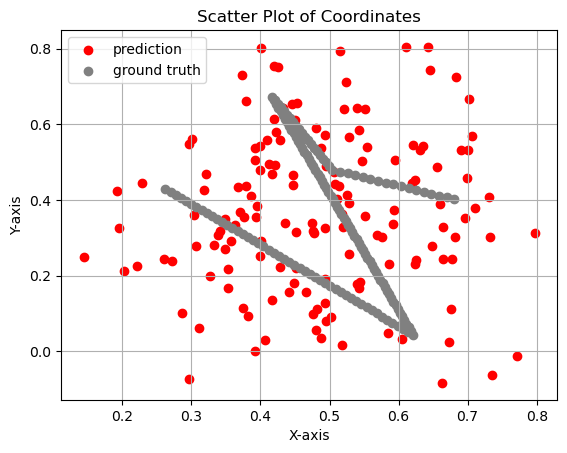

(150, 2)


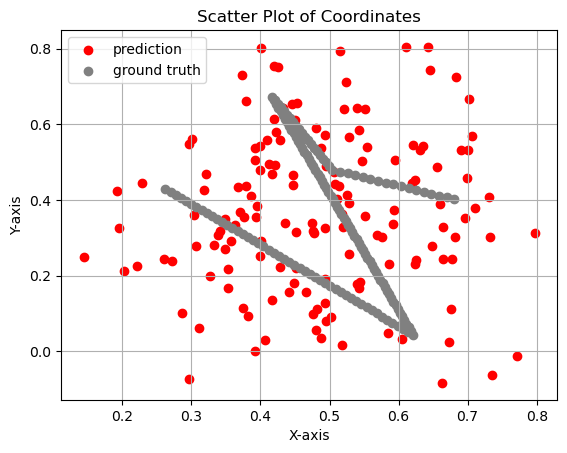

(150, 2)


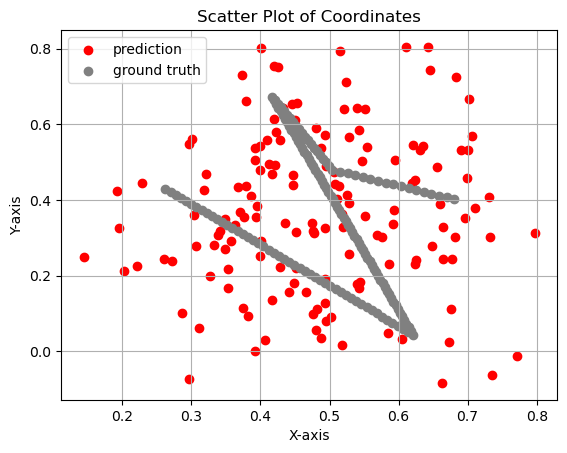

(150, 2)


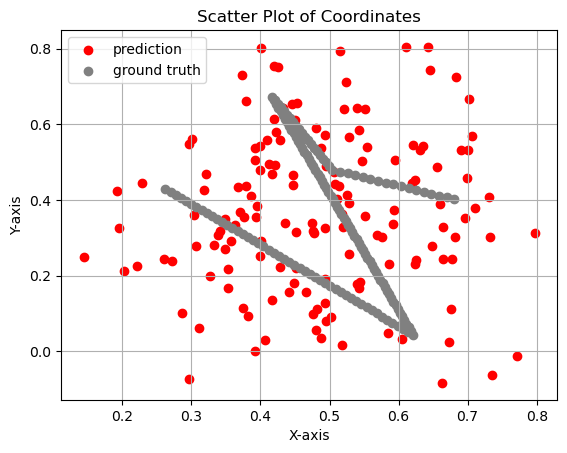

Time taken for the entire loop: 4.2796 seconds
Average time taken for one loop iteration: 2.1398 seconds
test_loss: 0.0127
Done!
Saved PyTorch Model: ./Dataset/pretrained/model_aug_bin150_batch6_normdata70_lr0001_ReLU_MSE_epoch30_NormBN.pth
It took 18.930450201034546s to run the file.


In [2]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import pandas as pd
import wandb
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
from model.model import UNet_2D
from utils.utils import EarlyStopping, plot_coordinates, save_images_as_movie
from utils.dataset import CustomImageDataset
torch.manual_seed(0)
import sys
import time

# x:-860 to -1100
# y: 650 to 950

# バージョン確認
print("torch       :", torch.__version__) # expect 2.1.2
print("torchvision :", torchvision.__version__) # expect 0.16.2

# GPUの確認
device = ("cuda" if torch.cuda.is_available() else "cpu")
print("device      :", device)
print("torch cuda  :", torch.version.cuda) # expect 12.1
torch.cuda.empty_cache()
# print(torch.cuda.memory_summary(device=None, abbreviated=False))


# 変更する必要のある変数
TITLE = "BrandSilence"
num_bin = 150

input_path = './Dataset/input_data/'
target_path = './Dataset/target_data/'
SIZE_X = 640
SIZE_Y = 480
learning_rate = 0.0001
epochs = 30
Loss = "MSE"
activation = "ReLU"
batch_size=6
norm = "BN"
flip_lr = 0.4
flip_ud = 0.4

def train(train_dl, val_dl, model, loss_fn, optimizer, epochs, batch, model_path):
    early_stopping = EarlyStopping(patience=12, verbose=True, path=model_path)
    # sys.stderr.write("error in train")
    for epoch in range(epochs):
        model.train()
        total_loss=0
        with tqdm(enumerate(train_dl), desc="[Epoch %d]" % (epoch), total=len(train_dl), leave=False, position=0) as pbar_loss:
            for batch, (X, y) in pbar_loss:
                # sys.stderr.write("error in train batch")
                X, y = X.to(device).to(torch.float), y.to(device).to(torch.float)
                # modelを変更の余地あり
                # assert X[0].shape == (150, 480, 640)
                # frames_np = X.to('cpu').detach().numpy()[0]*255
                # print(frames_np.shape)
                # save_images_as_movie('./video1.mp4',frames_np, 50)
                # return
                pred = model(X)
                loss = loss_fn(pred, y)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
        avg_loss = total_loss / len(train_dl)
        # Call EarlyStopping
        early_stopping(avg_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break
        wandb.log({"train_loss": avg_loss})
        print('last batch value: ', batch)
        print('avg_loss: ', avg_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch, (X, y) in tqdm(enumerate(val_dl), desc=f"Valodation {epoch+1} Batches", ncols=100, position=2, leave=False, total=len(val_dl)):
                X, y = X.to(device).to(torch.float), y.to(device).to(torch.float)
                pred = model(X)
                loss = loss_fn(pred, y)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_dl)
        wandb.log({"val_loss": avg_val_loss})
        if epoch%5==0:
            pred_np = pred.cpu().numpy()
            y_np = y.cpu().numpy()
            for i in range(len(pred)):
                plot_coordinates(pred_np[i], y_np[i])


def test(test_dl, model, loss_fn):
    # prediction = np.array()
    model.eval()
    total_loss = 0
    start_time = time.time()
    with torch.no_grad():
        for batch, (X, y) in tqdm(enumerate(test_dl), desc="Testing Batches", ncols=100, position=3, leave=False, total=len(test_dl)):
            X, y = X.to(device).to(torch.float), y.to(device).to(torch.float)
            pred = model(X)
            print('prediction shape: ', pred.shape)
            loss = loss_fn(pred, y)

            total_loss += loss.item()
            if batch == 1:
                assert X[0].shape == (150, 480, 640)
                frames_np = X.to('cpu').detach().numpy()[0]*255
                print(frames_np.shape)
                save_images_as_movie('./video2.mp4',frames_np, 50)
                print('this is ground truth: ', y[0])
                print('this is prediction: ', pred[0])
    pred_np = pred.to('cpu').numpy()
    # print('pred_np shape: ', pred_np.shape)
    y_np = y.to('cpu').numpy()
    print(f'y_np shape: {y_np.shape}, pred_np shape: {pred_np.shape}')
    print('this is y_np: ', y_np[0])
    print('this is pred_np: ', pred_np[0])
    for i in range(len(pred)):
        plot_coordinates(pred_np[i], y_np[i])
    end_time = time.time()
    elapsed_time = end_time - start_time  # Calculate the elapsed time for the entire loop
    avg_time_per_loop = elapsed_time / len(test_dl) # Calculate the average time per loop
    print(f"Time taken for the entire loop: {elapsed_time:.4f} seconds")
    print(f"Average time taken for one loop iteration: {avg_time_per_loop:.4f} seconds")
    avg_loss = total_loss / len(test_dl)
    print(f"test_loss: {avg_loss:.4f}")

def main():
    start = time.time()

    dataset = CustomImageDataset(input_dir=input_path, target_dir=target_path, title=TITLE, num_bin=num_bin)
    train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset) - 300, 200, 100]) # (700, 200, 100)になるように
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    data_num = len(train_dataset)
    parameters = "aug_bin" + str(num_bin) \
        + "_batch" + str(batch_size) \
            + "_normdata" + str(data_num)  \
                + "_lr" + str(learning_rate).split('.')[1] \
                    + "_" + activation \
                        + "_" + Loss \
                            + "_epoch"+ str(epochs) \
                                + "_Norm" + str(norm)
    model_path = "./Dataset/pretrained/model_" + parameters + ".pth"
    wandb.init(
        project = "event-based_NLOS",
        name = parameters,
        config={
            "train_data_num": data_num,
            "learning_rate": learning_rate,
            "activation": activation,
            "train_loss": Loss,
            "epochs": epochs,
            "num_bin": num_bin,
            "batches": batch_size,
            "Norm": norm
        }
    )

    # define model
    unet = UNet_2D().to(device)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(unet.parameters(), lr=learning_rate)

    print('training start')
    train(train_dataloader, validation_dataloader, unet, loss_fn, optimizer, epochs, batch_size, model_path)
    print('training completed, start testing')
    wandb.finish()
    torch.save(unet.state_dict(), model_path)
    # unet.load_state_dict(torch.load(model_path))
    test(test_dataloader, unet, loss_fn)
    end = time.time()
    print("Done!")
    print("Saved PyTorch Model: " + model_path)
    elapsed_time = end - start
    print(f"It took {elapsed_time}s to run the file.")


if __name__ == "__main__":
    main()
